# Moving beyond linearity
 In Chapter 6 we see that we can
improve upon least squares using ridge regression, the lasso, principal components regression, and other techniques. In that setting, the improvement
is obtained by reducing the complexity of the linear model, and hence the
variance of the estimates. But we are still using a linear model, which can
only be improved so far! In this chapter we relax the linearity assumption
while still attempting to maintain as much interpretability as possible.

We will also try to build our intuition arround the abstract ideas of **basis functions** and **GAMs** (which i regard as the most powerfull ideas of this chapter) by slowly understanding its concrete instances like poly regs and step functions. This bottom-up approach seems to work well for me and i hope it does to you as well!

# TLDR;

- **Polynomial Regression**: use powers of the predictor $x_i$ as predictors in a linear regression
- **Step Functions**: split predictor space into finite subsets and fit each subset $c_i \leq X \leq c_{i+1}$ as a constant function of value $ \beta_i $
- **splines**: fit picewise polynomials for each subset of predictor space. Impose some estrictions in order to make de fitted curve continuous and smooth (continuity of derivatives)
- **Basis Functions**: a generalization to represent a non lineaer function as a linear combination of basis functions of the estimator
- **Generalized Additive Models**: Generalizes the idea of basis functions to multiple predictors of multiple variables ($x_{i0}, x_{i1}, x_{i2},x_{j0}, x_{j1}, x_{j2}, \ldots , x_{in}, x_{jm}$)

# Import and explore data

In [2]:
import pandas as pd
import numpy as np
from IPython.display import YouTubeVideo
import seaborn as sns
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt

def display_yotube_video(url, **kwargs):
    """
    Displays a Youtube video in a Jupyter notebook.
    
    Args:
        url (string): a link to a Youtube video.
        **kwargs: further arguments for IPython.display.YouTubeVideo
    
    Returns:
        YouTubeVideo: a video that is displayed in your notebook.
    """
    id_ = url.split("=")[-1]
    return YouTubeVideo(id_, **kwargs)

## Preprocess values

In [3]:
data = pd.read_csv(r'../../data/raw/wage.csv')
data.head(1)

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154


In [4]:
for col in data.dtypes[data.dtypes == 'O'].index:    
    data[col] = data[col].apply(lambda x: x.split('.')[-1])
data.head(1)

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,Male,Never Married,White,< HS Grad,Middle Atlantic,Industrial,<=Good,No,4.318063,75.043154


## Data profile

In [5]:
profile = ProfileReport(data)
profile

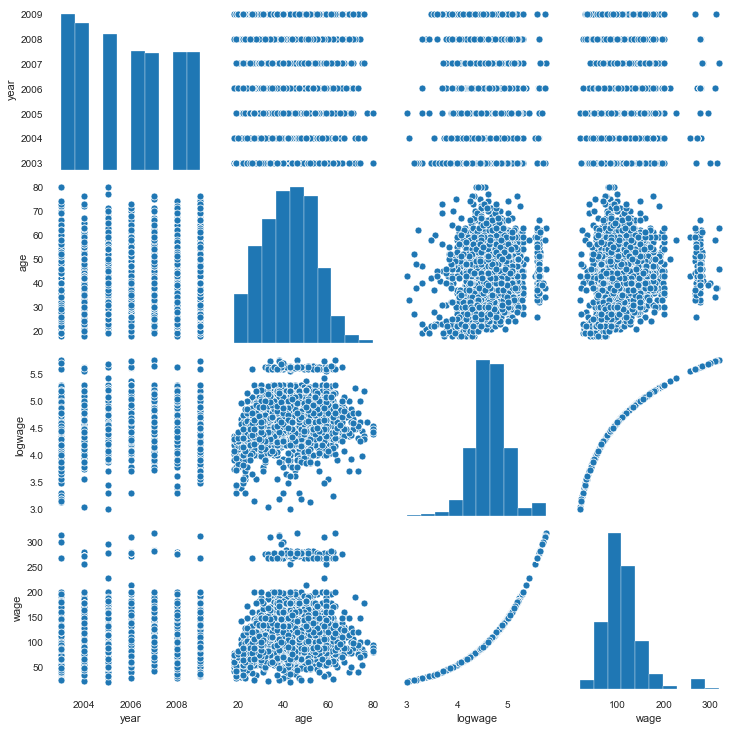

In [5]:
%matplotlib inline
sns.pairplot(data)

# Polynomial regression
Historically, the standard way to extend linear regression to settings in
which the relationship between the predictors and the response is nonlinear has been to replace the standard linear model

$$ i_i = \beta_0 + \beta_1 X_i + \epsilon_i$$

With a polynomial function

$$ y_i = \beta_0 + \beta_1 X_i^1 + \beta_2 X_i^2 + \beta_3 X_i^3 + \ldots + \beta_d X_i^d + \epsilon_i$$

Notice that the coefficients in (2) can be easily estimated
using least squares linear regression because this is just a standard linear
model with predictors $x_i, x_i^2, \ldots , x_i^d$. Generally speaking, it is unusual
to use d greater than 3 or 4 because for large values of d, the polynomial
curve can become overly flexible and can take on some very strange shapes, which may lead to overfitting, due to high variance.

### Polynomial regression in python

As mentioned earlier, a polynomial regression can be regarded as multi estimator linear function, in which each estimator is a power of $x_i$. For that reason, we'll use sklearn's [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), and make powers of $x_i$ (feature 'age') using python's built in power(**) operator

In [7]:
from sklearn.linear_model import LinearRegression

In [15]:
import numpy as np
degree = 4
regressor = LinearRegression()

X = []
for p in range(1,degree+1):
    # for each power, create an estimator
    estimator = data['age']**p
    X.append(estimator.values.tolist())
#concatenate all estimators
X = np.array(X).T
y = data['wage'].values

In [9]:
regressor.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
data[f'd{degree}_preds'] = regressor.predict(X)
data[f'd{degree}_std_e'] = (data[f'd{degree}_preds'] - data['wage'])

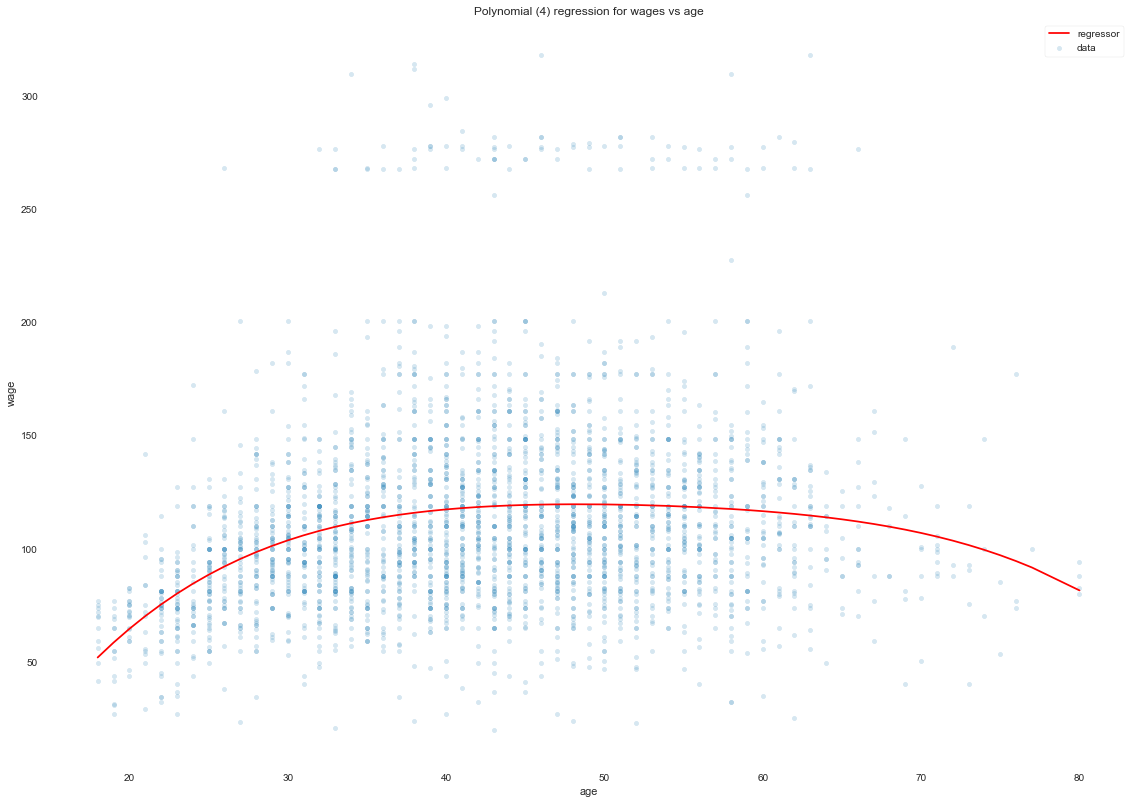

In [14]:
fig, ax = plt.subplots(1)
data.plot.scatter('age', 'wage', alpha = 0.2, label = 'data', ax = ax)
data.set_index('age')[f'd{degree}_preds'].sort_index().plot(color = 'r', label = 'regressor', ax = ax)

plt.title(f'Polynomial ({degree}) regression for wages vs age')
plt.legend()
plt.subplots_adjust(right=2, top=2)

### Polynomial classification (Logistic Regression)
It seems like the wages are from **two distinct populations**:
there appears to be a high earners group earning more than $250,000 
 *per annum* , as well as a low earners group. We can treat wage as a binary
variable by splitting it into these two groups. Logistic regression can then
be used to predict this binary response, using polynomial functions of age
as predictors. In other words, we fit the model

$$Pr(y_i > 250|x_i) = \frac{exp (\beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \ldots +  \beta_d x_i^d)}{1+ exp (\beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \ldots +  \beta_d x_i^d)}$$


Where $\beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \ldots  + \beta_d x_i^d$ is our nonlinear logit function.

Lets begin creating our categorical variable

In [11]:
data['>250'] = (data['wage'] > 250).astype(int)

### Polynomial LogisticRegression

A class that extends standard logistic regression with polynomial logit functions. powers features from a pd.DataFrame as input and applies Logistic regression with the new estimators

In [12]:
from sklearn.linear_model import LogisticRegression
class PolyRegPandas(LogisticRegression):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def _list(self, data):
        if data.__class__ in [list, tuple, set]:
            data = list(data)
        else:
            data = [data]
        return data
            
    def _make_estim(self, data, col, degree):
        X = []
        for p in range(1,degree+1):
            estimator = data[col]**p
            X.append(estimator.values.tolist())
        X = np.array(X).T
        return X
    
    def fit(self, data, estimators, target, degree, **kwargs):
        estimators = self._list(estimators)
        
        X = np.concatenate([self._make_estim(data, estim, degree) for estim in estimators],axis = 1)
        y = data[target].values
        super().fit(X,y)
        
        self.degree = degree
        self.estimators = estimators
        self.target = target
        return self
    
    def predict(self, data):
        
        X = np.concatenate([self._make_estim(data, estim, self.degree) for estim in self.estimators],axis = 1)
        result = super().predict(X)
        return result

    def predict_proba(self, data):
        
        X = np.concatenate([self._make_estim(data, estim, self.degree) for estim in self.estimators],axis = 1)
        result = super().predict_proba(X)
        return result
        

In [13]:
classifier = PolyRegPandas(class_weight = None, max_iter = 100)
classifier.fit(data,'age','>250', degree = 4)
preds = classifier.predict_proba(data)
data['proba >250'] = preds[:,1]

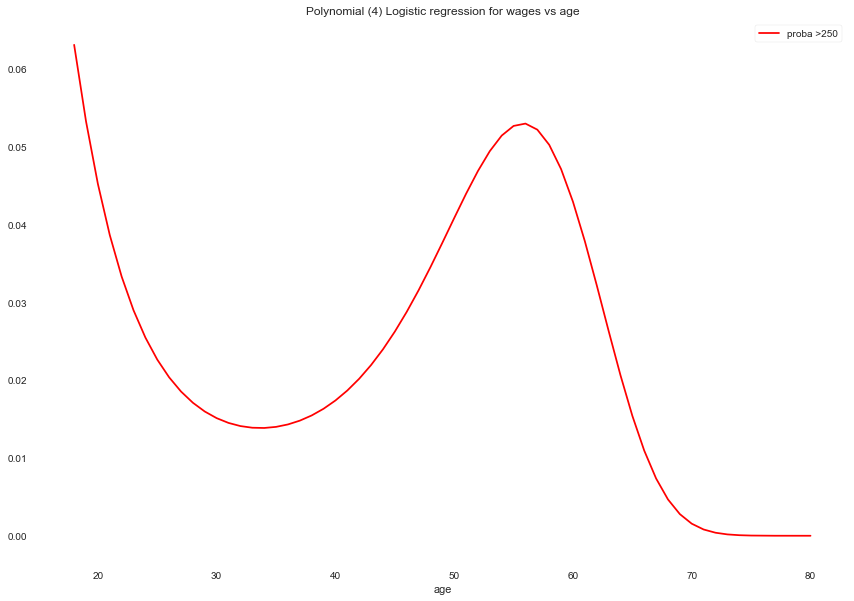

In [14]:
data.set_index('age')['proba >250'].sort_index().plot(color = 'r', label = 'proba >250')
plt.title(f'Polynomial ({degree}) Logistic regression for wages vs age')
plt.legend()
plt.subplots_adjust(right=2, top=2)

# Step Functions

Using polynomial functions of the features as predictors in a linear model
imposes a global structure on the non-linear function of X. That is, **no matter the value of $x_i$, the same rules apply**.
We can instead use step functions in order to avoid imposing such a global structure. Here step function:
we break the range of X into bins, and fit a different constant in each bin.
This amounts to converting a continuous variable into an ordered categorical variable.

In greater detail, we create cutpoints $c_1, c_2,\ldots,c_K$ in the range of $X$,
and then construct $K + 1$ new variables

$$
C_0  = I(X < c_1) \\
C_1  = I(c_2 \leq X < c_1) \\
C_2  = I(c_3 \leq X < c_2) \\
\vdots \\
C_2  = I(c_{K-1} \leq X < c_K) \\
C_2  = I(c_K \leq X) \\
$$

where $I(·)$ is an indicator function that returns a 1 if the condition is true, indicator
and returns a 0 otherwise. These are sometimes called dummy variables.

We then use least squares to fit a linear model using $C_1(X), C_2(X),\ldots,C_K(X)$ as predictors:\


$$ y_i = \beta_0 + \beta_1 C_1(x_i) + \beta_2 C_2(x_i) + \ldots + \beta_K C_K(x_i) + \epsilon_i$$\

For a given value of $X$, at most one of $C_1, C_2,...,C_K$ can be non-zero.
Note that when $X<c_1$, all of the predictors in (5) are zero, so $\beta_0$ can
be interpreted as the mean value of $Y$ for $X<c1$. By comparison, (5)
predicts a response of $\beta_0+\beta_j$ for $c_j ≤ X<c_{j+1}$, so $β_j$ represents the average increase in the response for $X$ in $c_j ≤ X<c_j+1$ relative to $X<c_1$.

Unfortunately, unless there are natural breakpoints in the predictors,
piecewise-constant functions can miss the action.

## Step Functions in python

If we give some thought to the step function formulation, it may rewind uns of another machine learning algorithm: **decision tree regressors!** 
In fact, decision trees do the exact same thing, except for the fact that, in contrary to the step function aforemetioned, it selects the nobs (or splitting points) according to some goodness of fit criteria.

For didatic purposes, we can define a step function as described above:

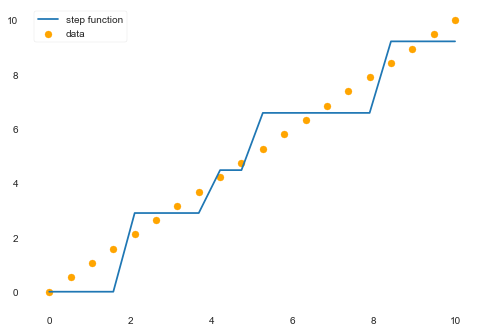

In [31]:
def step_function(arr, start, end):
    result = np.zeros(arr.shape)
    msk_1 = (arr >= start) & (arr < end)
    result[msk_1] = arr[msk_1].mean()
    return result


X = np.linspace(0, 10, 20)
y = step_function(X, 2, 4) + step_function(X, 4, 5) + step_function(X, 5, 8) + + step_function(X, 8, 11)
plt.plot(X, y, label = 'step function')
plt.scatter(X,X, color = 'orange', label = 'data')
plt.legend()

Now lets apply a decision tree to our model, setting our max_depth to 2 (n splits yields $2^n$ estimators)

In [20]:
from sklearn.tree import DecisionTreeRegressor

In [25]:
tree = DecisionTreeRegressor(max_depth = 2)
tree.fit(data[['age']],data['wage'])
data['preds'] = tree.predict(data[['age']])

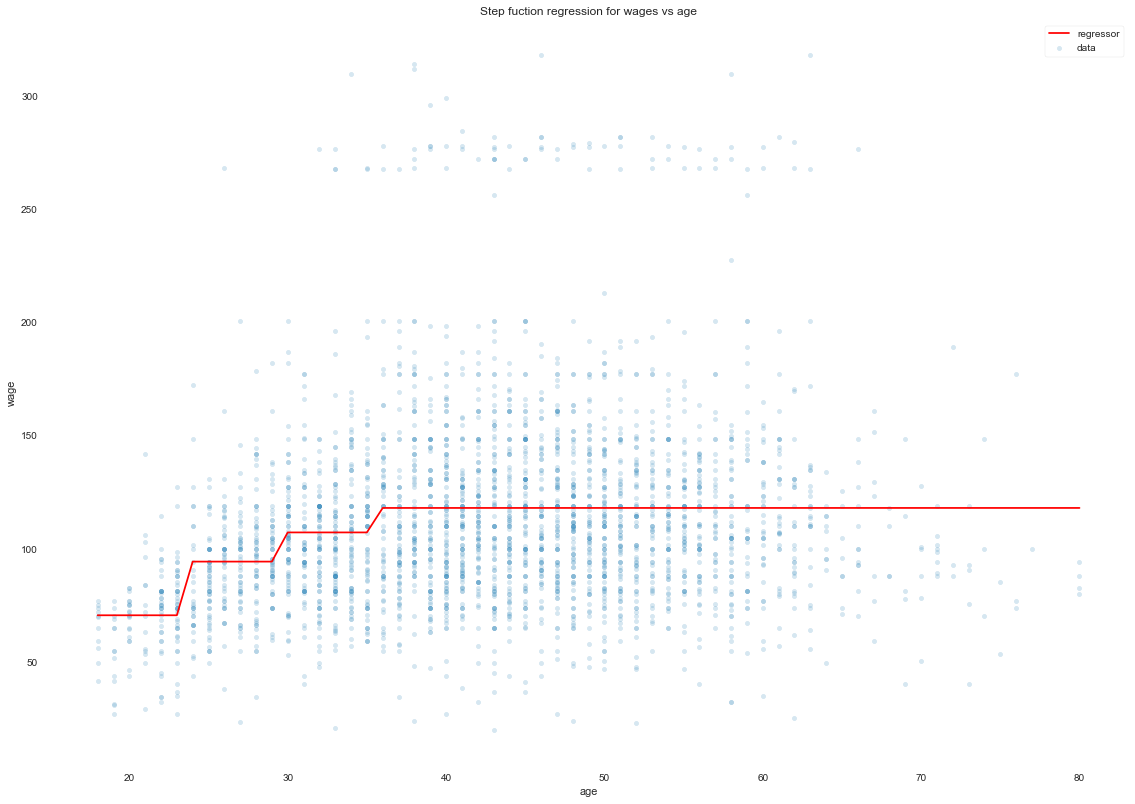

In [26]:
data.plot.scatter('age', 'wage', alpha = 0.2, label = 'data')
data.set_index('age')['preds'].sort_index().plot(color = 'r', label = 'regressor')

plt.title(f'Step fuction regression for wages vs age')
plt.legend()
plt.subplots_adjust(right=2, top=2)

The same procedure can be done using the DecisionTreeClassifier class form sklearn

# Splines

Splines are analogous to picewise function, but insetad of fitting a vanila model for each subset of the $x_i$ space (estimators of the model), we fit a polynomial of $x_i$ for each of the intervals. 

Splines are also subject to constraints in order to make them continuous and smooth(continuity of first derivative), as we can see in the image below:

<img src="extra/splines.png">

The amount and position of the knots can be chosen by the model definer judment (i.e. regions with higher variange of data contains more knots) or can be choosen automatically otpimizing some loss function (once fixed the degrees of freedom)

# Smoothing splines

Smotthing splines introduces a 'wigliness' regularizer to loss function. Meaning that regions with abrupt variations will be penalized (and thus less frequent). this penalization term is generaly done by introducing a $\lambda$ term that multiplies the integral of the second derivative of the fitted function (note that this now requires the function to have a **continuous second derivative**):

$$ \sum^{n}_{i = 1}(y_i- g(x_i))^2 + \lambda \int   g''(t).dt $$

<img src="extra/smoothing_splines.png">


# Basis functions
If we look carefully, all the sessions above can be seen as an instance of a more generic formulation for non-linear functions. We can see that if all cases we have a linear combination (scaling and summation) of 'basis' functions of the estimator $x_i$. We can write down this generalized formulation as:

$$ y_i = \beta_0 + \beta_1 b_1(x_i) + \beta_2 b_2(x_i) + \ldots + \beta_K b_K(x_i) + \epsilon_i$$\

where each term $ \beta_k b_k(x_i)$ can be seen as a new estimator and $b_k$ is a non-linear function. for the case of polynomials, $b_k(x_i) = x_i^k$. For the step fucntion, $b_k(x_i) = C_k(x_i)$, and so on. Now what we have is a linear combination of non linear functions. if we consider $b_k(x_i)$ as a new estimator $x'_k$, we then have the following formulation:

$$ y_i = \beta_0 + \beta_1 x'_0 + \beta_2 x'_1 + \ldots + \beta_K x'_{K-1} + \epsilon_i$$\

**Which is the formulation of a linear regression, as we've seen before**

## A little more about Basis Functions and Abstract Vector Spaces

So, we know we can describe a point in space in term of multiples of basis vectors (say, $(\hat{i}, \hat{j}) = ((1,0),(0,1))$ 
where, for instace, a point like $(x_0,y_0) = (7,4)$ can be described as a linear combination of basis vectors: $(7,4) = 7\hat{i} + 4\hat{j}$.
But know we can create an intuition of 'function spaces', in which we describe points in space as **linear combinations of basis functions(!)** (instead of basis vectors)

This can make us get a sense of **Linearity beyond the vanilla concept of linearity**, which is commonly regarded as something "straight-line-ish". We now describe linearity as (roughly) as the condition of obeying some properties of summation and scaling.

This notion is better represented in the video bellow, specially from _7:05 to 9:06_ and _11:11 to 12:48_.

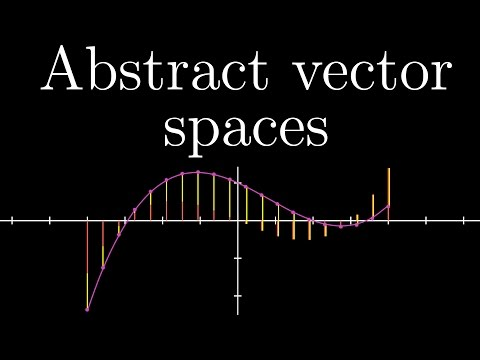

In [27]:
display_yotube_video("https://www.youtube.com/watch?v=TgKwz5Ikpc8", width=800, height=600)

## Different types of basis functions
### Interpretability
We can get really creative when selection a suitable basis function. According to the application, we can represent functions that would otherwise be hard to interpret as a set of summation and scalling of basis functions (or components), which gives us the advent of interpretabilty **(as long as the transformations applied to our estimators are also interpretable)**.

<center><img src="extra/uq.png"></center>
<center><i>Figure: Example of hard to interpret linearization. Note the tittle of X axis.</i></center>

### Time series

The ideia of decomposition in terms of basis functions os very useful in time series analysis (whith trend, level and seasonality decomposition):

<center><img src="extra/time_series.png"></center>
      <center><i>Figure: Multiplicative time series decomposition. multiplicative effects become additive with a log transform.</i></center>

note that all the components are a function of time $f_i(t)$ except from $\epsilon_i$ (random noise). The model becomes:

$$y = trend(t) + seasonal(t) + \epsilon_i$$

### Fourier series and spectrum decomposition
Another very famous application of basis functions is the fourier transform, which enables an enormous amount of applications.
We can see one of them in the video bellow(0:50- 2:40):

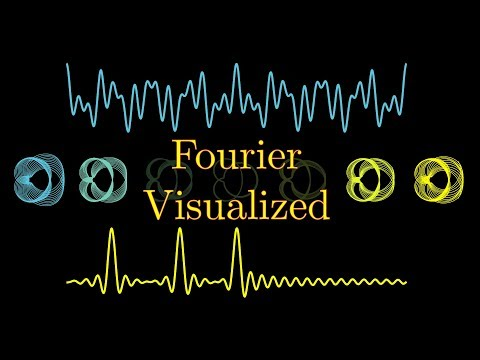

In [28]:
display_yotube_video("https://www.youtube.com/watch?v=spUNpyF58BY", width=800, height=600)

The **matematical machine** mentioned in the video could be seen as the selection of a suitable set of basis functions that meets our needs (make a chord as a linear combination of single notes, for those who are into music)!

### Fourier in the complex domain
For those who found this example intresting, check the next one out! It's also related to oscliating basis functions (but now in the complex plane)!

check (14:00 - 16:52)

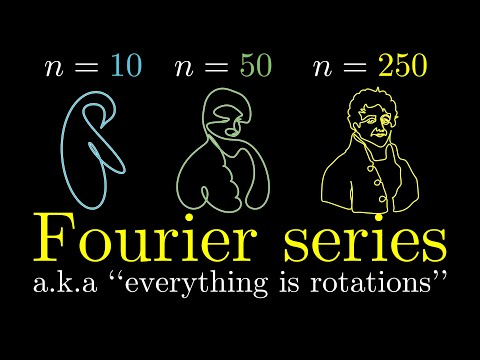

In [29]:
display_yotube_video("https://www.youtube.com/watch?v=r6sGWTCMz2k", width=800, height=600)

In that case, our variable $x_i$ is used to create new estimators using the complex basis functions $e^{k*2 \pi i x_i}$
Remebemr that you can choose any kind of 'vector-ish' thing, so both real and complex functions are included. And that brings us back to our formulation of linear combination of basis functions:

$$ y_i = \beta_0 + \beta_1 b_1(x_i) + \beta_2 b_2(x_i) + \ldots + \beta_K b_K(x_i) + \epsilon_i$$\

where $b_k(x_i) = e^{2 \pi k i x_i}$


Note that the author of the video mentions that there must be found parameters {$C_i, \ldots ,C_K$} that best fits our model, given the data, which resembles the problem of finding {$\beta_i, \ldots, \beta_K$} in our former definition of linear models.

# General Adittive Models

Now that we have (hopefully) built and intuition around the abstract concept of basis functions, it may be much easier to understand General Aditive Models (or GAMs)

They can be seen as the extension of base function models, but using more features rather than just $x_i$. The estimators for each feature (age,  year, education ...) can be any one of those mentioned before, and we can represent a GAM, for this case, simply as:

$$wage = \beta_0 + f_1(age) + f_2(year) + f_3(education) + \epsilon $$

where each of these $f$'s are choosen conveninetly (splines, polynomials, step functions...)

The interpretability comes from the **marginal effect** graphs, which plots the effect of each feature, keeping the other features effects unnaltered:

<img src="extra/GAMs.png">

GAMs in python can be used with the [PyGAM](https://pygam.readthedocs.io/en/latest/) library, which also contains some builtin functinalitys for marginal effect analysis!

# Conclusion

What we can conclude from this notebook is that dealing with non-linearities is very important in boosting our models performance. What is not linear sometimes can be transformed in a conveninet manner to fit the broad linearity definition. The interpretability of the results of such models depend highly on the interpretability of its marginal effects, alongside with the interpretability of the basis function itself.

As a downside, we see that although the models shown can capture nonlinear structure **within each feature**, they're not able to capture **interactions between features**, which may be very usefull in some cases. We can also mention that the selection of a suitable nonlinear basis function can be a hard task and may require a lot of expertise. For problems that requires such interactions and must have a generic (one-fits-all) basis function, some other techniques can be applied, such as Multi Layer Perceptron (MLP or Dense Neural Nets) or decision trees (when a split is made constraining one feature **and** another feature, this can be seen as an interaction between them).



# A brief note on [mappings](https://en.wikipedia.org/wiki/Maps_of_manifolds) and [linear separability](https://en.wikipedia.org/wiki/Linear_separability)

An intesresting way of viewing the task of such non-linear, interaction aware algorithms (Trees, neural nets...), at least for clssification perspective, is mapping the feature space to a new space in which the classes become lienarly separable (as much as possible).

It's like unwrapping a globe to a planisphere (mapping from spherical coordinates to cartesian coordinates) in order to be able to separate Africa and America with a straight line (ruler). The analogous of such straight line in a planisphere is an arc. Other kind of spaces have also different analogous versions of a 'straight line', the task is generally to find the mapping function that optimizes some goodness of fit criteria in class separation.